In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps
from math import pi
from pde import PDE, CartesianGrid, MemoryStorage, ScalarField

In [44]:
def plot_solution(x, t, u, main_str):
    plt.figure()
    plt.pcolormesh(x, t, u)
    plt.xlabel('x', fontsize=16)
    plt.ylabel('t', fontsize=16)
    plt.title(main_str, fontsize=16)
    plt.colorbar()

In [97]:
a = 1  # wave speed
b = 0.1  # diffusivity
solution_name = "u"
equation = PDE({solution_name: f"- {a} * d_dx(u) + {b} * laplace(u)"},
                # bc={"value": "cos(x)"}
                )

x_min = -2*pi
x_max = pi*2
x_num_elements = 64  

grid = CartesianGrid([[x_min, x_max]], [x_num_elements], periodic=True)
state = ScalarField.from_expression(grid, "cos(x*2)")

t_max = pi  # to preserve scaling
t_num_elements = 256

storage = MemoryStorage()
result = equation.solve(state, t_range=t_max, tracker=storage.tracker(t_max/t_num_elements))

x = np.ravel(storage.grid.axes_coords)
t = np.ravel(storage.times)
u = np.real(storage.data)

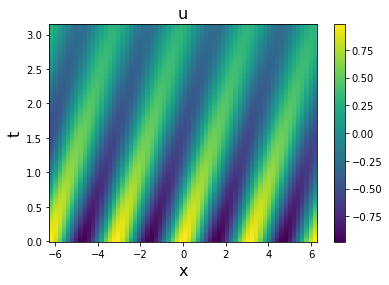

In [98]:
plot_solution(x, t, u, solution_name)

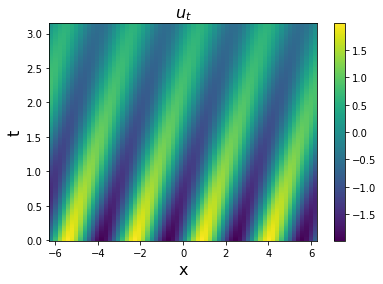

In [99]:
dt = t[1] - t[0]
for i in range(1, 2):
    u_i = ps.FiniteDifference(d=i, axis=0)._differentiate(u, t=dt)
    suffix = "t"*i
    plot_solution(x, t, u_i, f"${solution_name}_{suffix}$")


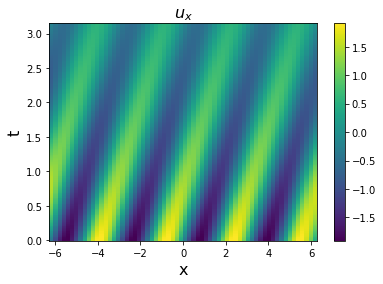

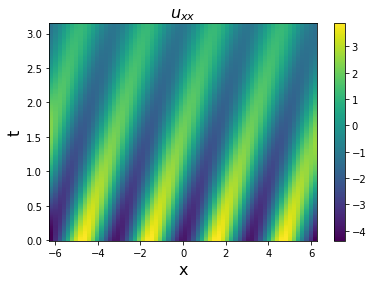

In [100]:
dx = x[1] - x[0]
for i in range(1, 3):
    u_i = ps.FiniteDifference(d=i, axis=1)._differentiate(u, t=dx)
    suffix = "x"*i
    plot_solution(x, t, u_i, f"${solution_name}_{{{suffix}}}$")

In [121]:
def get_model():
    library_functions = [lambda x: x, lambda x: x * x]
    library_function_names = [lambda x: x, lambda x: x + x]

    pde_lib = ps.PDELibrary(library_functions=library_functions, 
                            function_names=library_function_names, 
                            derivative_order=2, spatial_grid=x, 
                            include_bias=True, is_uniform=True
                            )
    optimizer=ps.STLSQ(threshold=20, alpha=1e-5, normalize_columns=True)
    model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=solution_name)
    return(model)

def print_result(model):
    print("Feature library:")
    print(clean_model.feature_library.get_feature_names(solution_name))
    print("STLSQ model:")
    model.print()

In [122]:
clean_model = get_model()
u_reshaped = np.transpose(u).reshape(len(x), len(t), 1)
clean_model.fit(u_reshaped, t=dt)
print_result(clean_model)

Feature library:
['1', 'u', 'uu', 'u_1', 'u_11', 'uu_1', 'uuu_1', 'uu_11', 'uuu_11']
STLSQ model:
(u)' = -0.394 u + -0.997 u_1
